In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
from datetime import datetime
import math
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
batch_size =32
seq_len = 96
pre_len = 96
learning_rate = 0.005
train_epoch = 10
period = 4
size = [seq_len,pre_len]
transformer_dim=128
target = 'M' #MS

dataset = 'ETTh1'   
dataset_root= './{}.csv'.format(dataset)
checkpoint_path = './{}_weight/{}/'.format(dataset,pre_len)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset_Custom_train(Dataset):
    def __init__(self,  flag):     
        self.seq_len = seq_len    
        self.pre_len = pre_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        
        self.features = 'M'
        self.target = 'OT'
        self.scale = True
        
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(dataset_root,parse_dates=['date'])

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''

        cols = list(df_raw.columns)
            
        cols.remove('date')
        num_train = int(len(df_raw) * (0.7))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw[cols]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
    
        self.data_x = data[border1:border2]
   
        #STL
        STL_Data = pd.DataFrame(self.data_x) 
        self.s,self.t,self.l = self.stl(STL_Data)

    def stl(self,STL_Data):
        cols = STL_Data.columns
        channels = len(cols)

        s = torch.zeros([len(STL_Data), channels], dtype=torch.float32)
        t = torch.zeros([len(STL_Data), channels], dtype=torch.float32)
        l = torch.zeros([len(STL_Data), channels], dtype=torch.float32)

        for i ,col in enumerate(cols):
            df = STL_Data[col]   
            res = STL(df, period=period).fit()  
            s[:, i] = torch.tensor(np.array(res.seasonal.values), dtype=torch.float32)
            t[:, i] = torch.tensor(np.array(res.trend.values), dtype=torch.float32)
            l[:, i] = torch.tensor(np.array(res.resid.values), dtype=torch.float32)
        return s,t,l

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        
        r_begin = s_end 
        r_end = r_begin + self.pre_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_x[r_begin:r_end]
             
        #global_stl
        s = self.s[s_begin:s_end]
        t = self.t[s_begin:s_end]
        l = self.l[s_begin:s_end]
        global_stl = (s,t,l)
        
        #local_stl
        s1,t1,l1 =  self.stl(pd.DataFrame(seq_x))
        local_stl = (s1,t1,l1)

        return seq_x, seq_y, global_stl,local_stl
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pre_len + 1




In [4]:
def data_provider(flag):
    Data = Dataset_Custom_train   
    train_only = False
    if flag == 'test':
        shuffle_flag = False
        drop_last = False
        
    else:
        shuffle_flag = True
        drop_last = True
        

    data_set = Data(
        flag='train'   
    )
     
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=0,
        drop_last=True)
    return data_set, data_loader

def _get_data(flag):
    data_set, data_loader = data_provider(flag)
    return data_set, data_loader

In [5]:
class Rescontruct_F(nn.Module):
    def __init__(self,):
        super(Rescontruct_F, self).__init__()
        # Nlinear
        self.Linear1 = nn.Linear(seq_len, seq_len).to(device)
        
        #Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim,
                                                        nhead=8,
                                                        dropout=0.1,
                                                        batch_first=True).to(device)
        
        self.Transnformer_encoder = nn.TransformerEncoder(self.encoder_layer,
                                                   num_layers=3).to(device)
        self.Linear2 = nn.Linear(seq_len,transformer_dim)
        self.Linear3 = nn.Linear(transformer_dim,seq_len)

    def forward(self, x, flag):
        if flag == "Nlinear":
            seq_last = x[:, -1:, :].detach()
            x = x - seq_last
            x = self.Linear1(x.permute(0, 2, 1)).permute(0, 2, 1)
            x = x + seq_last
            return x
        if flag == "Encoder":
            x = self.Linear2(x.permute(0, 2, 1))
            x = self.Transnformer_encoder(x)
            x = self.Linear3(x).permute(0, 2, 1)    
            return x



In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()      
        # re
        self.Rescontruct_F = Rescontruct_F().to(device)
        
        # pre
        self.l1 = nn.Linear(seq_len, pre_len).to(device)
        self.l2 = nn.Linear(seq_len, pre_len).to(device)


    def forward(self, x,flag):
        if flag == "pre":       
            s,l,t = x         
            seq_last_t = t[:, -1:, :].detach()
            t = t - seq_last_t
            t = self.l1(t.permute(0, 2, 1)).permute(0, 2, 1)
            t = t + seq_last_t
            
            seq_last_s = s[:, -1:, :].detach()
            s = s - seq_last_s
            s = self.l2(s.permute(0, 2, 1)).permute(0, 2, 1)
            s = s + seq_last_s
            x = s+t         
            return x
        if flag == "Reconstruct":
            s, t, l = x   
            Reconstruct_list = []
            
            R_s = self.Rescontruct_F(s, flag = "Nlinear")
            Reconstruct_list.append(R_s)
            
            R_l = self.Rescontruct_F(l, flag = "Nlinear")
            Reconstruct_list.append(R_l)
            
             
            R_t = self.Rescontruct_F(t, flag = "Encoder")
            Reconstruct_list.append(R_t)
         
            return Reconstruct_list


In [7]:
model = MLP().to(device)

In [8]:
def train(model):
    train_data, train_loader = _get_data(flag='train')
    vali_data, vali_loader = _get_data(flag='val')
    model_optim = optim.Adam(model.parameters(),lr=0.001)
    criterion = nn.MSELoss()
    model.train()     
    
    for epoch in range(train_epoch):     
        r_s_loss =[]
        r_t_loss =[]
        r_l_loss =[]
        r_total_loss = []
        
        pre_epoch_loss = []
        
        #draw
        r_s1_draw =[]
        r_t1_draw =[]
        r_l1_draw =[]
        
        g_s_draw =[]
        g_t_draw =[]
        g_l_draw =[]
        
        pre_draw = []
        y_draw = []
        
        
        for i, (x, y, global_stl,local_stl) in enumerate(train_loader):      
            s,t,l = global_stl
            s1,t1,l1 = local_stl          

            #reconstruction input
            s1 = s1.float().to(device)
            t1 = t1.float().to(device)
            l1 = l1.float().to(device)
            
            s = s.float().to(device)
            t = t.float().to(device)
            l = l.float().to(device)
            
            x = x.float().to(device)
            #reconstruction 
            input1 = (s1,t1,l1)
            r_s1, r_l1, r_t1= model(input1,flag = "Reconstruct")
            
            #pre
            input2 = (r_s1, r_l1, r_t1)
            pre_result = model(input2,flag = "pre")
            
            r_loss1 = criterion(r_s1, s) 
            r_loss2 = criterion(r_t1, t) 
            r_loss3 = criterion(r_l1, l) 
            r_loss = r_loss1 + r_loss2 + r_loss3
            
            f_dim = -1 if target== 'MS' else 0
            pre_result = pre_result[:, -pre_len:, f_dim:]
            y = y[:, -pre_len:, f_dim:]
            
            
            #pre 
            y = y.float().to(device)     
            pre_loss = criterion(pre_result,y)
            
            #梯度下降
            loss = r_loss + pre_loss         
            model_optim.zero_grad()   
            loss.backward()
            model_optim.step()
            #print loss
            r_s_loss.append(r_loss1.item())
            r_t_loss.append(r_loss2.item())
            r_l_loss.append(r_loss3.item())
            r_total_loss.append(r_loss.item())
            
            pre_epoch_loss.append(pre_loss.item())
            #draw reconstruction
            r_s1_draw.append(r_s1[0,:,-1].detach().cpu().numpy())
            r_t1_draw.append(r_t1[0,:,-1].detach().cpu().numpy())
            r_l1_draw.append(r_l1[0,:,-1].detach().cpu().numpy())
            
            g_s_draw.append(s[0,:,-1].detach().cpu().numpy())
            g_t_draw.append(t[0,:,-1].detach().cpu().numpy())
            g_l_draw.append(l[0,:,-1].detach().cpu().numpy())
            
            #draw prediction
            pre_draw.append(pre_result[0,:,-1].detach().cpu().numpy())
            y_draw.append(y[0,:,-1].detach().cpu().numpy())
  
        r_total_loss = np.average(r_total_loss)
        r_s_loss = np.average(r_s_loss)
        r_t_loss = np.average(r_t_loss)
        r_l_loss = np.average(r_l_loss)
        pre_epoch_loss = np.average(pre_epoch_loss)

        print("{}".format(dataset),"train epoch:",epoch,"  r_total_loss:",r_total_loss,"  s,t,l: ",r_s_loss,r_t_loss,r_l_loss," pre_loss:",pre_epoch_loss)
        
        r_s1_draw = np.concatenate(r_s1_draw, axis=0)
        r_t1_draw = np.concatenate(r_t1_draw, axis=0)
        r_l1_draw = np.concatenate(r_l1_draw, axis=0)
        
        g_s_draw = np.concatenate(g_s_draw, axis=0)
        g_t_draw = np.concatenate(g_t_draw, axis=0)
        g_l_draw = np.concatenate(g_l_draw, axis=0)
        
        pre_draw = np.concatenate(pre_draw, axis=0)
        y_draw = np.concatenate(y_draw, axis=0)
        
        draw_length= -96
        #
        plt.subplots(figsize=(10, 10))
        plt.subplot(411)
        plt.xticks([])
        plt.plot(r_s1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_s_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_S')   
       
        plt.subplot(412)
        plt.xticks([])
        plt.plot(r_t1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_t_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_T')
        
        plt.subplot(413)
        plt.xticks([])
        plt.plot(r_l1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_l_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_L')
        
                
        plt.subplot(414) 
        plt.plot(pre_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(y_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('pre_result')
        plt.show()
    
    
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path, exist_ok=True)
        
    torch.save(model.state_dict(),checkpoint_path+"checkpoint.pth")    
    return model
        #vali_loss = vali(vali_data,vali_loader)

In [9]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("train start：", formatted_time)

train start： 2024-07-31 10:06:47


ETTh1 train epoch: 0   r_total_loss: 0.15134008369843166   s,t,l:  0.009591893328974645 0.11612053402264913 0.02562765657156706  pre_loss: 0.41601962653795876


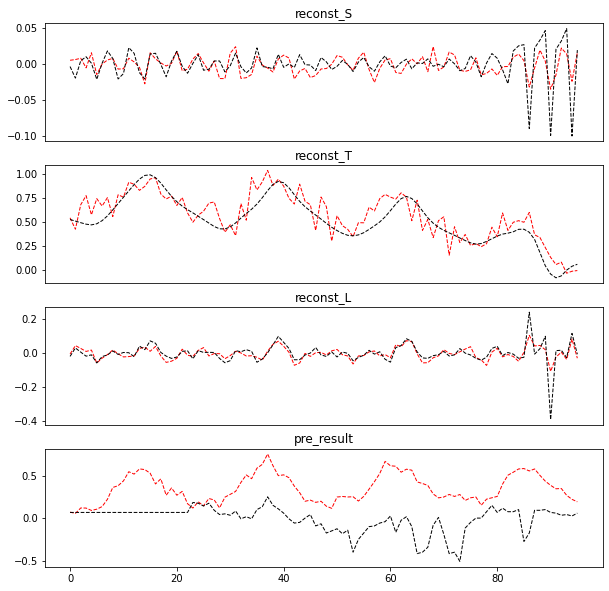

ETTh1 train epoch: 1   r_total_loss: 0.05859768204887708   s,t,l:  0.0039467874181767304 0.04542222083111604 0.009228673859188954  pre_loss: 0.3419710441827774


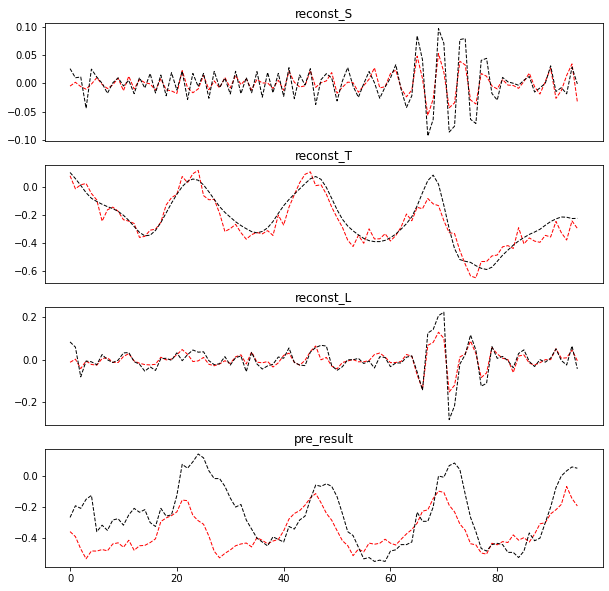

ETTh1 train epoch: 2   r_total_loss: 0.0456991865336895   s,t,l:  0.0022701568255821866 0.03897054632504781 0.00445848348364234  pre_loss: 0.3169844481945038


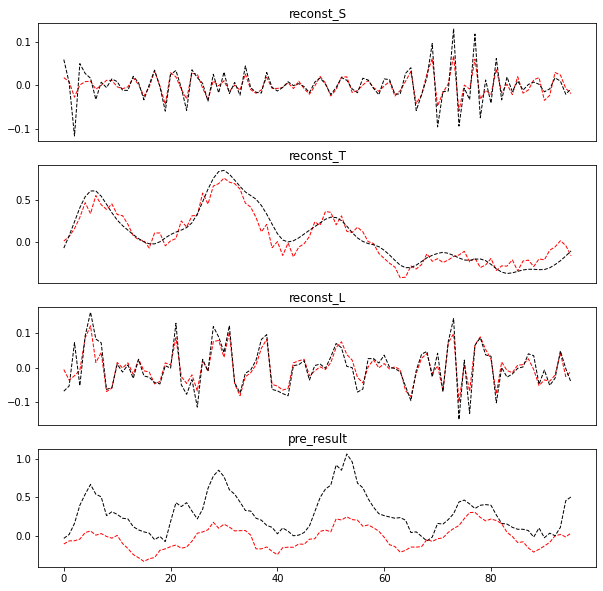

ETTh1 train epoch: 3   r_total_loss: 0.03849615462124348   s,t,l:  0.0014252341007813811 0.03448914369940758 0.0025817768337825934  pre_loss: 0.2930022954146067


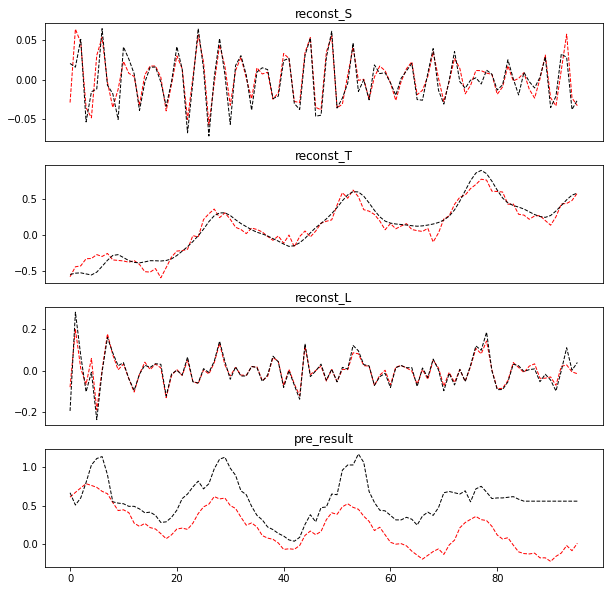

ETTh1 train epoch: 4   r_total_loss: 0.03578837311764558   s,t,l:  0.0010407402107181648 0.03290932520230611 0.0018383076464136441  pre_loss: 0.27489261106650037


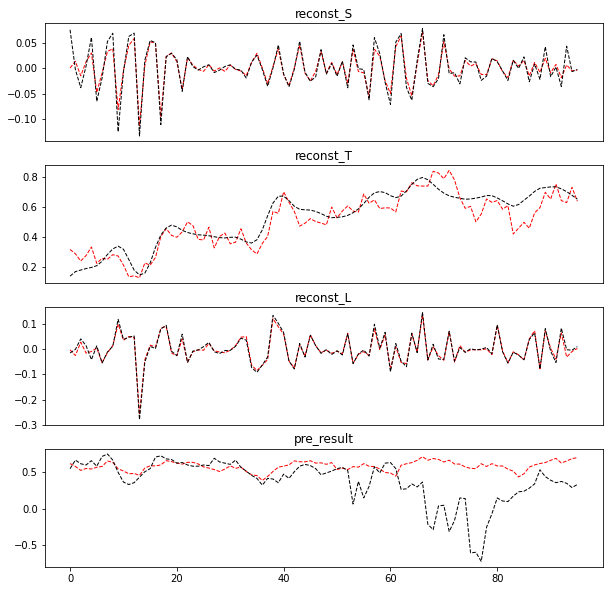

ETTh1 train epoch: 5   r_total_loss: 0.03282935897012552   s,t,l:  0.0008559182989411056 0.03044775437315305 0.0015256862823540965  pre_loss: 0.2577077099084854


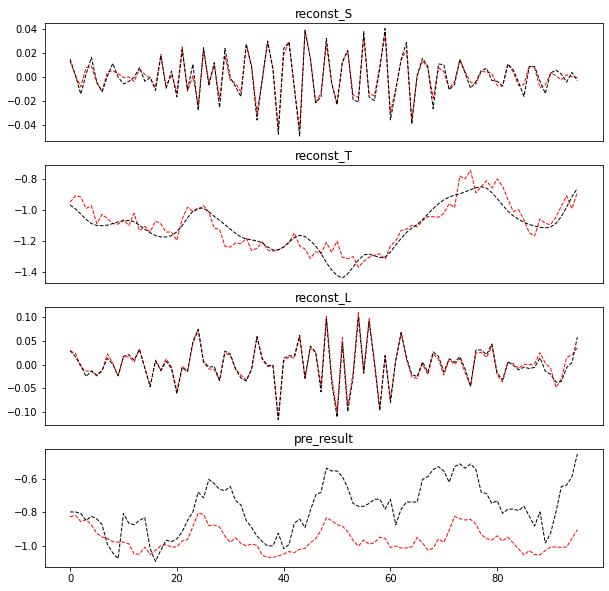

ETTh1 train epoch: 6   r_total_loss: 0.03065193749467532   s,t,l:  0.0007629758321369688 0.028505012363195418 0.0013839492706271509  pre_loss: 0.24032950965563457


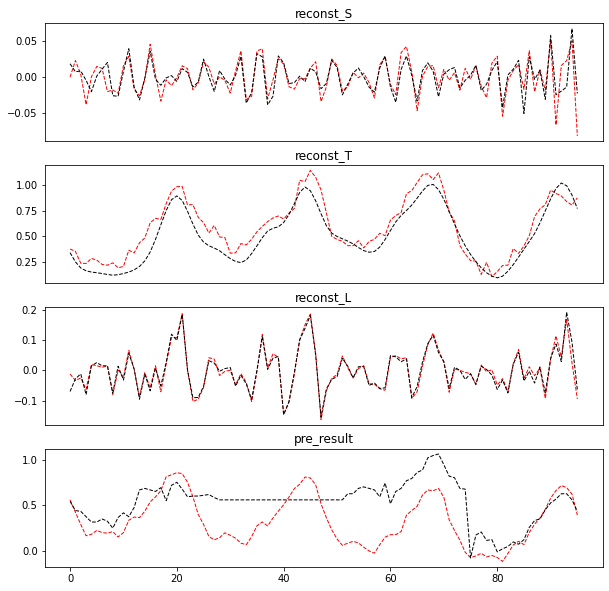

ETTh1 train epoch: 7   r_total_loss: 0.02919588119784991   s,t,l:  0.0007219314395139615 0.027156529814004897 0.001317419896212717  pre_loss: 0.22645086431503295


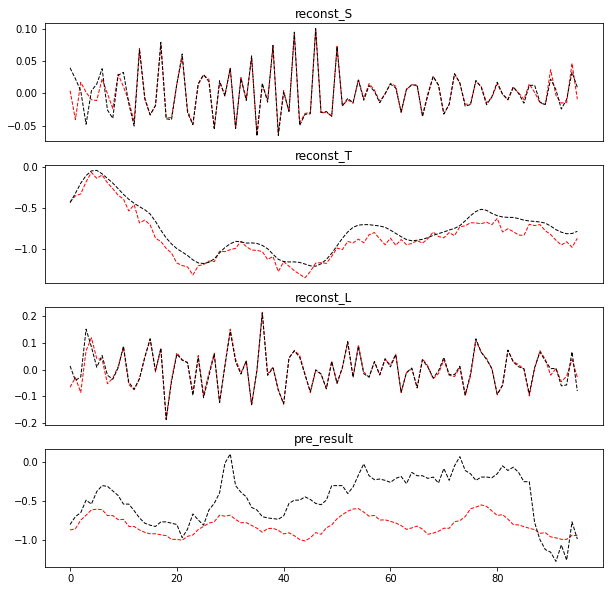

ETTh1 train epoch: 8   r_total_loss: 0.029094571123520534   s,t,l:  0.0006870245651031533 0.027132364551226296 0.001275181953329593  pre_loss: 0.2168716315428416


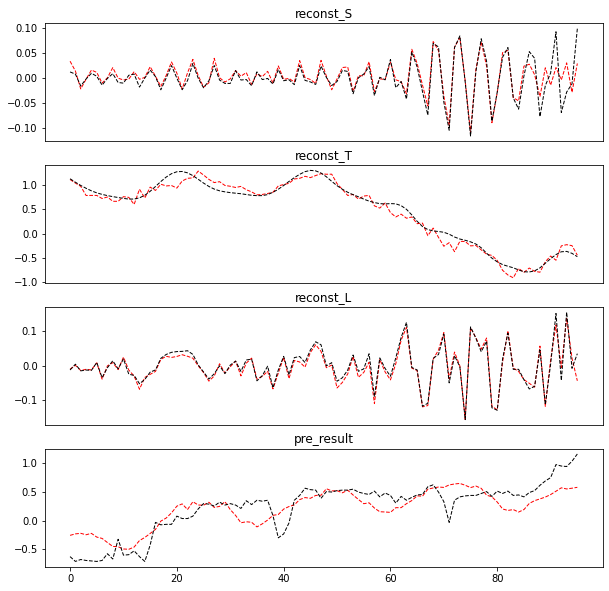

ETTh1 train epoch: 9   r_total_loss: 0.02785373889406522   s,t,l:  0.0006676397995712856 0.025938699652751286 0.001247399470458428  pre_loss: 0.20524730428059895


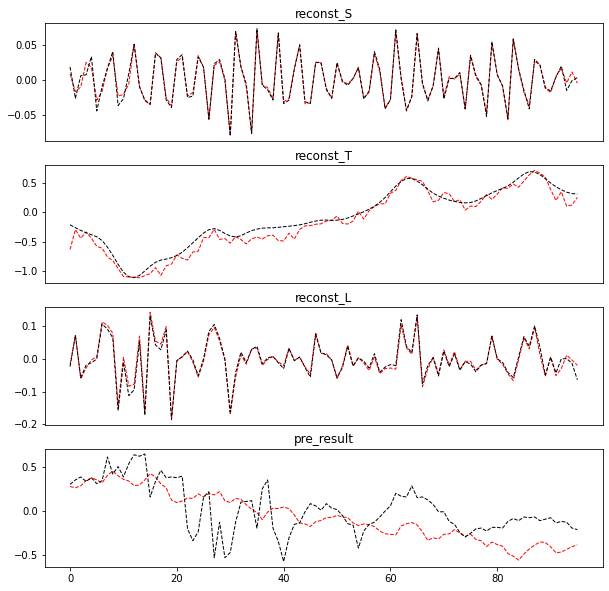

In [10]:
train_model = train(model)

In [11]:
def test(train_model):
    test_data, test_loader = _get_data(flag='test')
    criterion = nn.MSELoss()
    train_model.eval()
    with torch.no_grad():
        r_s_loss =[]
        r_t_loss =[]
        r_l_loss =[]
        r_total_loss = []
        pre_epoch_loss = []
        
        #draw  
        r_s1_draw =[]
        r_t1_draw =[]
        r_l1_draw =[]
        
        g_s_draw =[]
        g_t_draw =[]
        g_l_draw =[]
        
        pre_draw = []
        y_draw = []
        
        preds = []
        trues = []
        for i, (x, y,global_stl,local_stl) in enumerate(test_loader):  
            s,t,l = global_stl
            s1,t1,l1 = local_stl       

            #reconstruction input
            s1 = s1.float().to(device)
            t1 = t1.float().to(device)
            l1 = l1.float().to(device)
            x = x.float().to(device)
            
            
            s = s.float().to(device)
            t = t.float().to(device)
            l = l.float().to(device)
            
            
            #reconstruction 
            input1 = (s1,t1,l1)
            r_s1, r_l1, r_t1 = model(input1,flag = "Reconstruct")
            
            #pre
            input2 = (r_s1, r_l1, r_t1)
            pre_result = model(input2,flag = "pre")
            
            r_loss1 = criterion(r_s1, s) 
            r_loss2 = criterion(r_t1, t) 
            r_loss3 = criterion(r_l1, l) 
            r_loss = r_loss1 + r_loss2 + r_loss3
            
                        
            f_dim = -1 if target== 'MS' else 0
            pre_result = pre_result[:, -pre_len:, f_dim:]
            y = y[:, -pre_len:, f_dim:].float().to(device) 
            
            pre_loss = criterion(pre_result,y)
            
            #print loss
            r_s_loss.append(r_loss1.item())
            r_t_loss.append(r_loss2.item())
            r_l_loss.append(r_loss3.item())
            r_total_loss.append(r_loss.item())
            pre_epoch_loss.append(pre_loss.item())

            
            #draw reconstruction
            r_s1_draw.append(r_s1[0,:,-1].detach().cpu().numpy())
            r_t1_draw.append(r_t1[0,:,-1].detach().cpu().numpy())
            r_l1_draw.append(r_l1[0,:,-1].detach().cpu().numpy())
            
            g_s_draw.append(s[0,:,-1].detach().cpu().numpy())
            g_t_draw.append(t[0,:,-1].detach().cpu().numpy())
            g_l_draw.append(l[0,:,-1].detach().cpu().numpy())
            
            #draw prediction
            pre_draw.append(pre_result[0,:,-1].detach().cpu().numpy())
            y_draw.append(y[0,:,-1].detach().cpu().numpy())
            
           
            
            #mse,mae
            pre_result = pre_result.detach().cpu().numpy()

            y = y.detach().cpu().numpy()
            
            preds.append(pre_result)
            trues.append(y)
            

                
        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        mae = np.mean(np.abs(preds - trues))
        mse = np.mean((preds - trues) ** 2)
        print('mse:{}, mae:{}'.format(mse, mae))
                

        train_r_loss = np.average(r_total_loss)
        r_s_loss = np.average(r_s_loss)
        r_t_loss = np.average(r_t_loss)
        r_l_loss = np.average(r_l_loss)
        pre_epoch_loss = np.average(pre_epoch_loss)


        print("{}".format(dataset),"test:","  r_loss:",train_r_loss,"  s,t,l: ",r_s_loss,r_t_loss,r_l_loss," pre_loss:",pre_epoch_loss)
        
        #draw
        r_s1_draw = np.concatenate(r_s1_draw, axis=0)
        r_t1_draw = np.concatenate(r_t1_draw, axis=0)
        r_l1_draw = np.concatenate(r_l1_draw, axis=0)
        
        g_s_draw = np.concatenate(g_s_draw, axis=0)
        g_t_draw = np.concatenate(g_t_draw, axis=0)
        g_l_draw = np.concatenate(g_l_draw, axis=0)
        
        pre_draw = np.concatenate(pre_draw, axis=0)
        y_draw = np.concatenate(y_draw, axis=0)
        
        draw_length= -96
        plt.subplots(figsize=(10, 10))
        plt.subplot(411)
        plt.xticks([])
        plt.plot(r_s1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_s_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_S')   
       
        plt.subplot(412)
        plt.xticks([])
        plt.plot(r_t1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_t_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_T')
        
        plt.subplot(413)
        plt.xticks([])
        plt.plot(r_l1_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(g_l_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('reconst_L')
                 
        plt.subplot(414)
        plt.xticks([])
        plt.plot(pre_draw[draw_length:], color = 'red',linewidth=1,linestyle='--') 
        plt.plot(y_draw[draw_length:], color = 'black', linewidth=1,linestyle='--')
        plt.title('pre_result')
        plt.show()
        

mse:0.18564075231552124, mae:0.3108117878437042
ETTh1 test:   r_loss: 0.020712957753489414   s,t,l:  0.0006685545952835431 0.01881261901433269 0.0012317840593556563  pre_loss: 0.18564068899552028


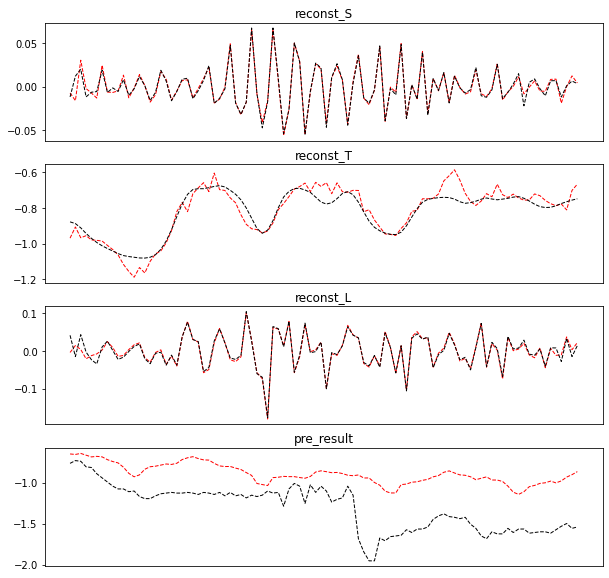

In [12]:
test(train_model)

In [13]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
print("train end：", formatted_time)

train end： 2024-07-31 10:22:01


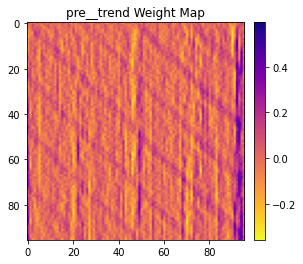

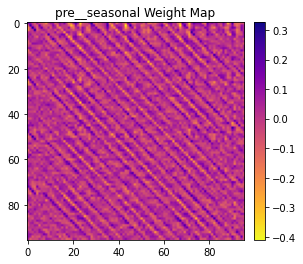

In [14]:
model_path = checkpoint_path+"checkpoint.pth"
if os.path.exists(model_path):
    weights = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(weights)
    weights_list = {}
    weights_list['pre__trend'] = model.l1.weight.detach().cpu().numpy()
    weights_list['pre__seasonal'] = model.l2.weight.detach().cpu().numpy()
    checkpoint_path = './{}_weight/{}/'.format(dataset,pre_len)

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path, exist_ok=True)

    for w_name, weight in weights_list.items():
        fig, ax = plt.subplots()
        im = ax.imshow(weight, cmap='plasma_r')
        fig.colorbar(im, pad=0.03)
        plt.title(f'{w_name} Weight Map')
        plt.savefig(os.path.join(checkpoint_path, f'{w_name}_weight_map.png'), dpi=500)
        plt.show()


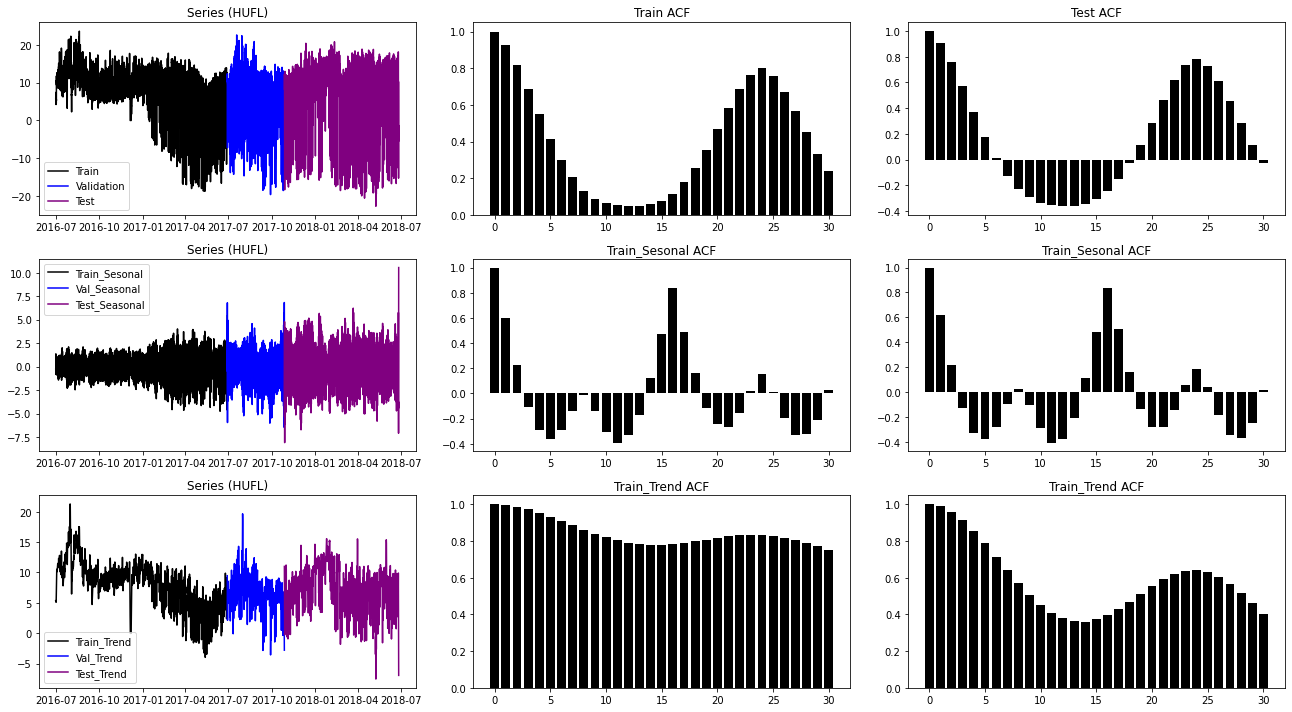

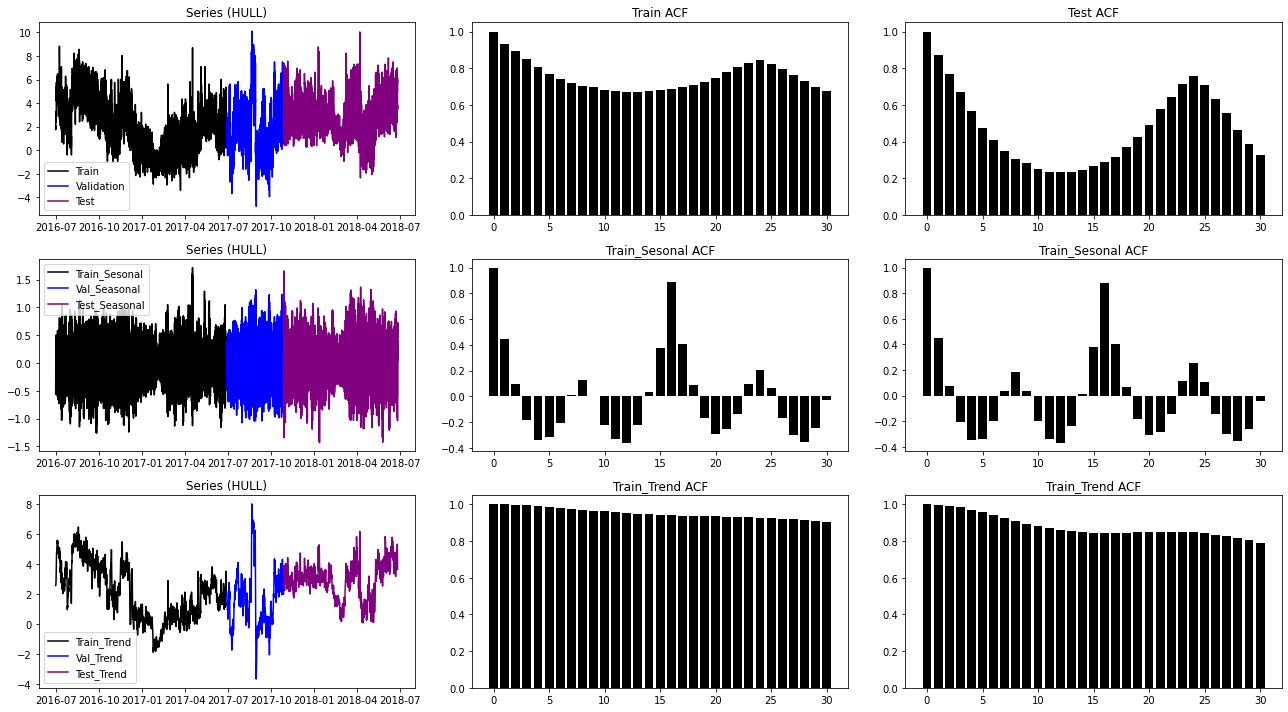

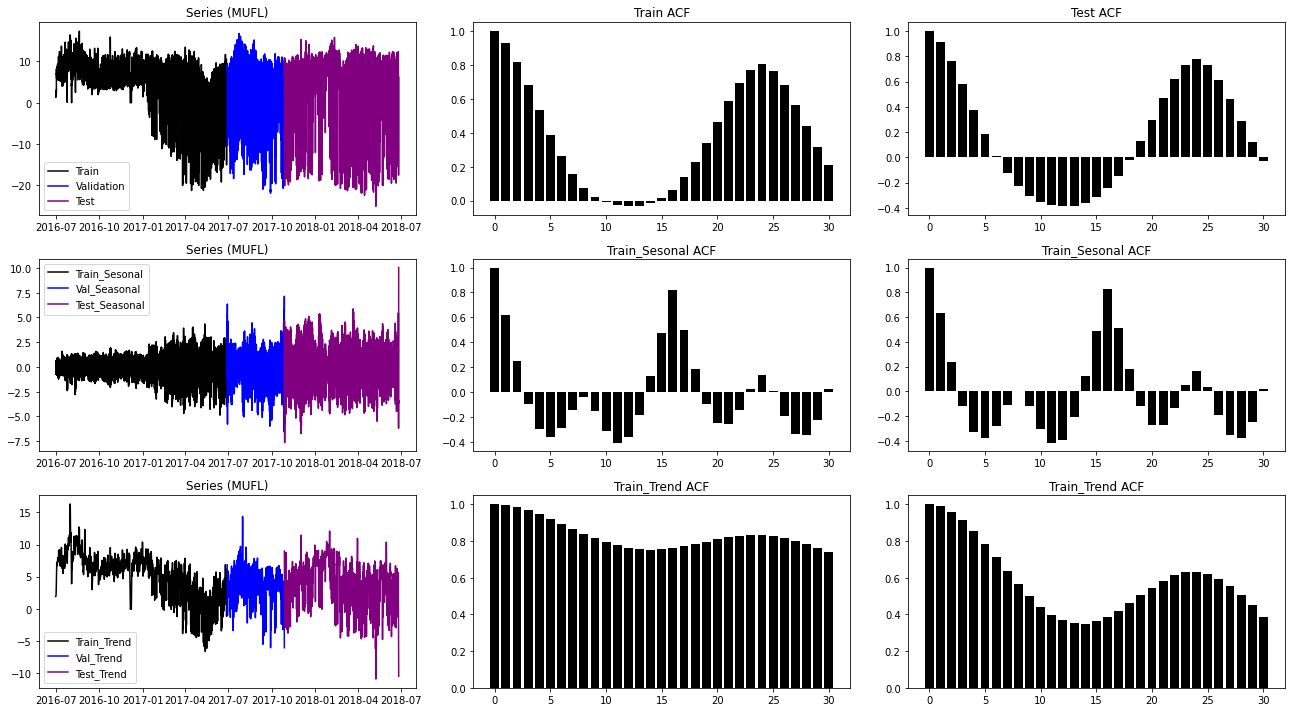

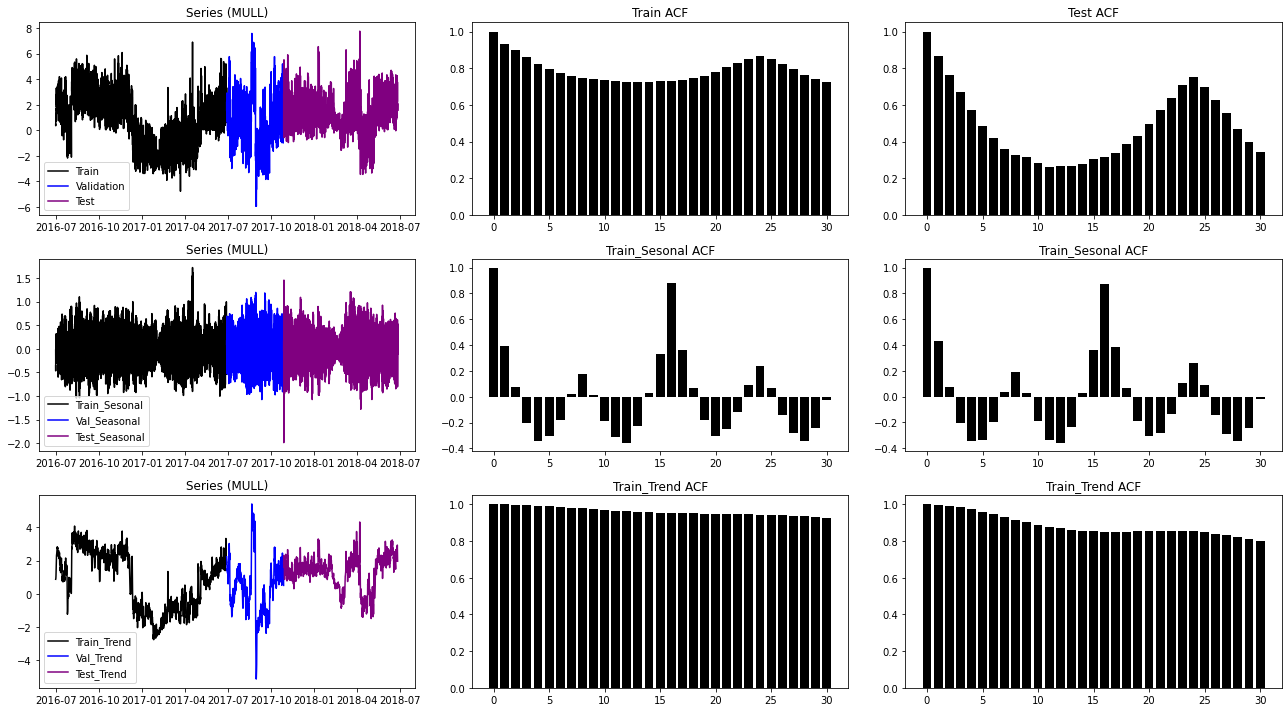

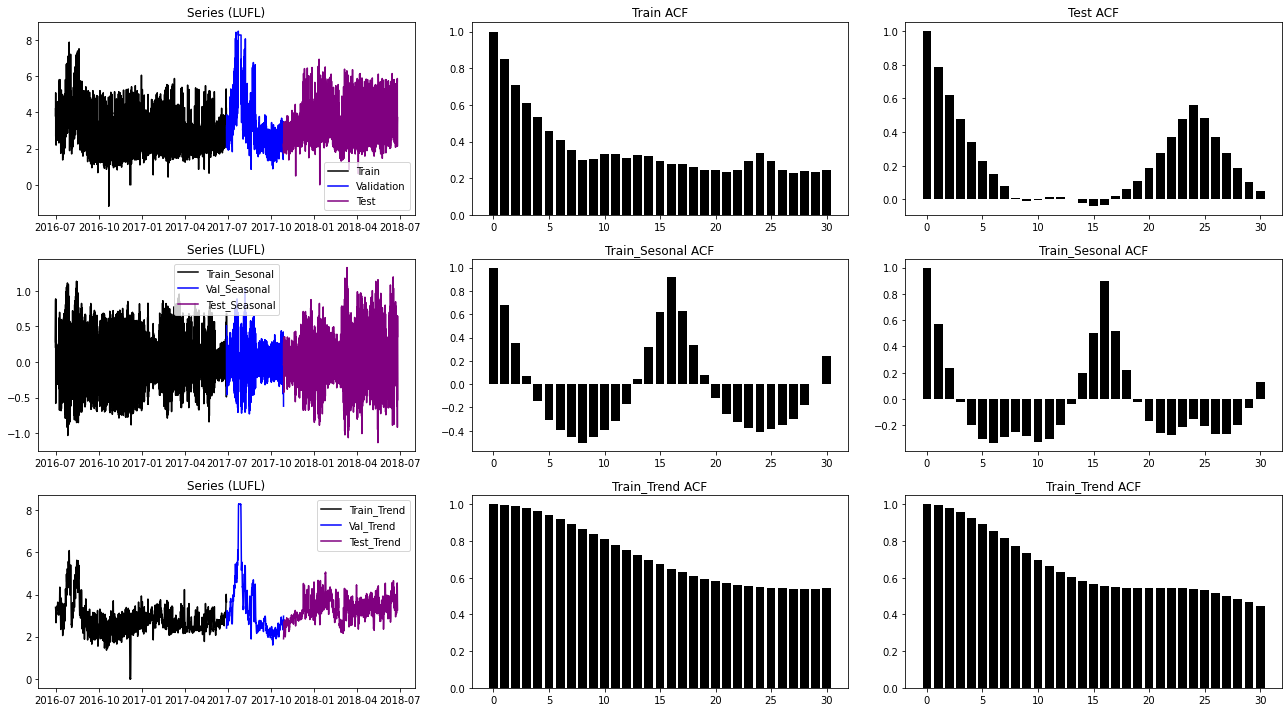

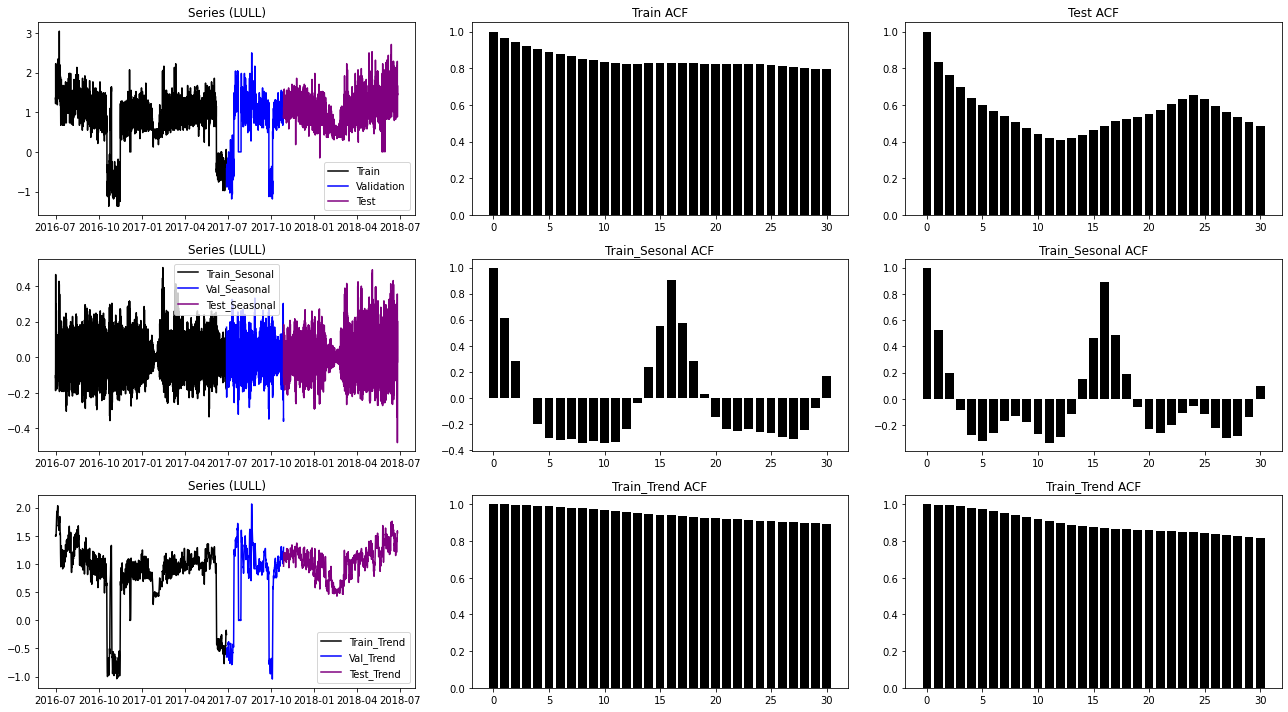

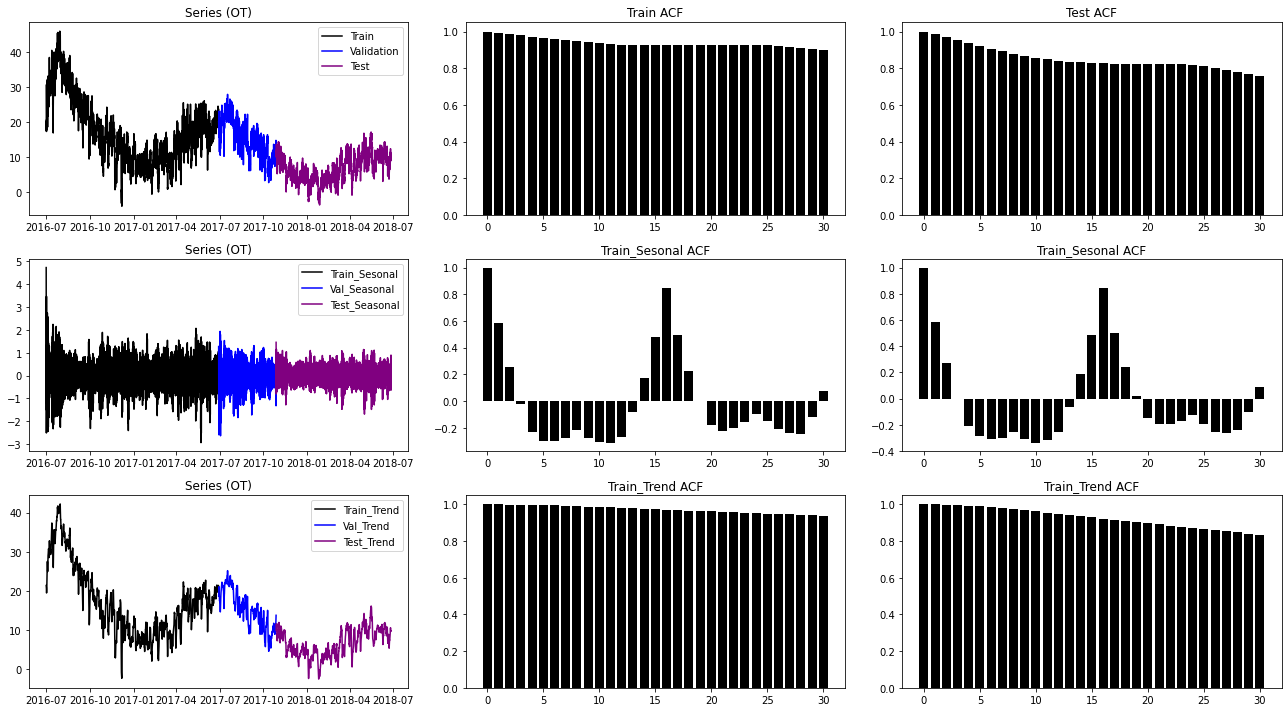

In [17]:
from statsmodels.tsa.stattools import acf

df = pd.read_csv(dataset_root, index_col='date', parse_dates=True)
# Define a function to split the dataset and plot the ACF graph
def plot_series_and_acf(data, column_name):
    # Calculate the index for splitting   #17420
    train_size = int(len(data) * 3 / 6)
    val_size = int(len(data) * 1 / 6)
    test_size = len(data) - train_size - val_size

    # Split the dataset
    train, val, test = np.split(data, [train_size, train_size + val_size])
    
    #STL
    #train
    STL_train = STL(train[column_name], period=16).fit()  # weather：6*24，ettm1:4x24
    STL_train_s = STL_train.seasonal
    STL_train_t = STL_train.trend
    
    #val
    STL_val = STL(val[column_name], period=16).fit() 
    STL_val_s = STL_val.seasonal
    STL_val_t = STL_val.trend
    #test
    STL_test = STL(test[column_name], period=16).fit()  # weather：6*24，ettm1:4x24
    STL_test_s = STL_test.seasonal
    STL_test_t = STL_test.trend
    
    # Calculate ACF
    train_acf = acf(train[column_name], nlags=30)
    test_acf = acf(test[column_name], nlags=30)
    
    train_acf_s = acf(STL_train_s, nlags=30)
    test_acf_s = acf(STL_test_s, nlags=30)
    
    train_acf_t = acf(STL_train_t, nlags=30)
    test_acf_t = acf(STL_test_t, nlags=30)
    
    # Create subplots
    fig, ax = plt.subplots(3, 3, figsize=(18, 10))  # Adjust the overall figure size
    # Plot the time series
    ax[0,0].plot(train.index, train[column_name], color='black', label='Train')
    ax[0,0].plot(val.index, val[column_name], color='blue', label='Validation')
    ax[0,0].plot(test.index, test[column_name], color='purple', label='Test')
    ax[0,0].legend()
    ax[0,0].set_title(f'Series ({column_name})')

    # Plot ACF for the training set
    ax[0,1].bar(range(len(train_acf)), train_acf, color='black')  # Set to black bars
    ax[0,1].set_title('Train ACF')

    # Plot ACF for the test set
    ax[0,2].bar(range(len(test_acf)), test_acf, color='black')  # Set to black bars
    ax[0,2].set_title('Test ACF')
        
    # seasonal
    ax[1,0].plot(STL_train_s.index, STL_train_s, color='black', label='Train_Sesonal')
    ax[1,0].plot(STL_val_s.index, STL_val_s, color='blue', label='Val_Seasonal')
    ax[1,0].plot(STL_test_s.index, STL_test_s, color='purple', label='Test_Seasonal')
    ax[1,0].legend()
    ax[1,0].set_title(f'Series ({column_name})')

    # Plot ACF for the test set
    ax[1,1].bar(range(len(train_acf_s)), train_acf_s, color='black')  # Set to black bars
    ax[1,1].set_title('Train_Sesonal ACF')
    
    ax[1,2].bar(range(len(test_acf_s)), (train_acf_s+test_acf_s)/2, color='black')  # Set to black bars
    ax[1,2].set_title('Train_Sesonal ACF')

    # trend
    ax[2,0].plot(STL_train_t.index, STL_train_t, color='black', label='Train_Trend')
    ax[2,0].plot(STL_val_t.index, STL_val_t, color='blue', label='Val_Trend')
    ax[2,0].plot(STL_test_t.index, STL_test_t, color='purple', label='Test_Trend')
    ax[2,0].legend()
    ax[2,0].set_title(f'Series ({column_name})')
    

    # Plot ACF for the test set
    ax[2,1].bar(range(len(train_acf_t)), train_acf_t, color='black')  # Set to black bars
    ax[2,1].set_title('Train_Trend ACF')
    
    ax[2,2].bar(range(len(test_acf_t)), test_acf_t, color='black')  # Set to black bars
    ax[2,2].set_title('Train_Trend ACF')
    # Adjust layout
    plt.tight_layout()   
    plt.show()

# Analyze each column except the date
if __name__ == "__main__":
    for column in df.columns:
        plot_series_and_acf(df, column)
        